In [1]:
import pandas as pd
import numpy as np
import pylab
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
register_matplotlib_converters()

Let's generate some data of the form

$y_t = 50 + 0.4\epsilon_{t - 1} + 0.3\epsilon_{t - 2} + \epsilon_t$

In [11]:
date_index = pd.date_range(start='9/1/2019', end='1/1/2021')
errors = np.random.normal(0, 1, len(date_index))

In [16]:
mu = 50
values = [50 + errors[0], 50 + errors[0]]
for t in range(2, len(date_index)):
    values.append(mu + 0.4 * errors[t - 1] + 0.3 * errors[t - 2] + errors[t])

In [17]:
series = pd.Series(values, date_index)
series = series.asfreq(pd.infer_freq(series.index))

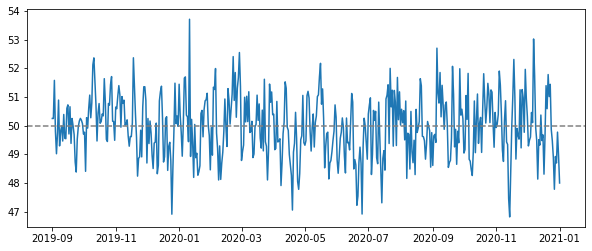

In [18]:
pylab.figure(figsize=(10,4))
pylab.plot(series)
pylab.axhline(mu, linestyle='--', color='grey')

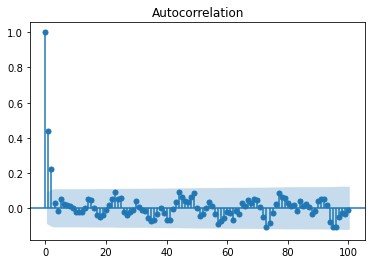

In [19]:
acf_plot = plot_acf(series, lags=100)

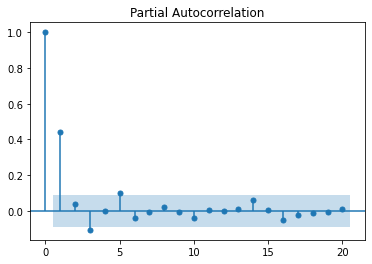

In [20]:
pacf_plot = plot_pacf(series, lags=20)

In [38]:
train_end = datetime(2020,12,30)
test_end = datetime(2021,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

In [39]:
#create the model
model = ARIMA(train_data, order=(0, 0, 2))

In [40]:
#fit the model
model_fit = model.fit()

In [41]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  487
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -669.712
Date:                Mon, 15 Feb 2021   AIC                           1347.424
Time:                        20:31:11   BIC                           1364.177
Sample:                    09-01-2019   HQIC                          1354.005
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9677      0.074    674.400      0.000      49.822      50.113
ma.L1          0.4110      0.045      9.229      0.000       0.324       0.498
ma.L2          0.2815      0.048      5.815      0.0

Our predicted model is:

$\hat{y_t} = 49.96 + 0.41\epsilon_{t - 1} + 0.28\epsilon_{t - 2}$

In [42]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [43]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [44]:
residuals = test_data - predictions

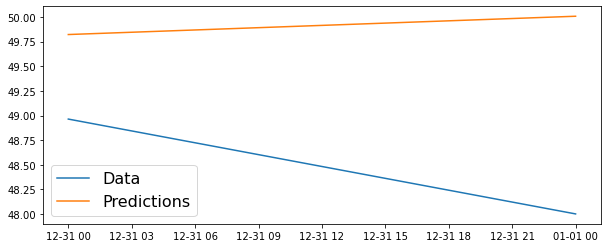

In [45]:
pylab.figure(figsize=(10,4))

pylab.plot(test_data)
pylab.plot(predictions)

pylab.legend(('Data', 'Predictions'), fontsize=16)

In [46]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0297


In [47]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.54305478789821


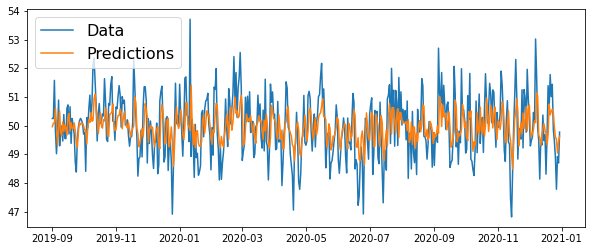

In [48]:
pylab.figure(figsize=(10,4))

pylab.plot(train_data)
pylab.plot(model_fit.predict(start=train_data.index[0], end=train_data.index[-1]))

pylab.legend(('Data', 'Predictions'), fontsize=16)